In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from scipy.stats import zscore
from datetime import timedelta
import random

In [3]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Charger les données
df = pd.read_excel("DATA.xlsx")

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 32 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   codeexam        100000 non-null  object        
 1   codedos         100000 non-null  int64         
 2   codeavisPP      100000 non-null  int64         
 3   objet           100000 non-null  object        
 4   codecatprojPP   100000 non-null  int64         
 5   codecontexte    100000 non-null  int64         
 6   codemo          100000 non-null  int64         
 7   sit             100000 non-null  object        
 8   supcv           100000 non-null  int64         
 9   suptr           100000 non-null  int64         
 10  supbt           100000 non-null  int64         
 11  invest          100000 non-null  int64         
 12  nblog           100000 non-null  int64         
 13  obs             100000 non-null  object        
 14  numcom          100000 non-null  int6

In [6]:
# Séparation des variables numériques et catégorielles
donnees_numeriques = df.select_dtypes(include=['int64', 'float64'])
donnees_categorielles = df.select_dtypes(include=['object', 'category'])

# Affichage pour vérification
print("Variables numériques :", donnees_numeriques.columns.tolist())
print("--- Informations sur les données numeriques ---")
print(donnees_numeriques.describe())
print("Variables catégorielles :", donnees_categorielles.columns.tolist())
print("--- Informations sur les données categorielles ---")
print(donnees_categorielles.describe())

Variables numériques : ['codedos', 'codeavisPP', 'codecatprojPP', 'codecontexte', 'codemo', 'supcv', 'suptr', 'supbt', 'invest', 'nblog', 'numcom', 'numexam', 'numfav', 'etat_dossier']
--- Informations sur les données numeriques ---
             codedos     codeavisPP  codecatprojPP  codecontexte  \
count  100000.000000  100000.000000  100000.000000  100000.00000   
mean   150000.500000       4.498890       5.501160       2.99992   
std     28867.657797       1.118093       2.865903       1.41444   
min    100001.000000       3.000000       1.000000       1.00000   
25%    125000.750000       3.000000       3.000000       2.00000   
50%    150000.500000       4.000000       5.000000       3.00000   
75%    175000.250000       5.000000       8.000000       4.00000   
max    200000.000000       6.000000      10.000000       5.00000   

              codemo     supcv          suptr          supbt        invest  \
count  100000.000000  100000.0  100000.000000  100000.000000  1.000000e+05  

In [7]:
# Vérifier les doublons dans toutes les colonnes
doublons = df[df.duplicated()]

# Afficher le nombre de doublons
print(f"Nombre de doublons : {doublons.shape[0]}")

Nombre de doublons : 0


In [8]:
print(df.isnull().sum())

codeexam             0
codedos              0
codeavisPP           0
objet                0
codecatprojPP        0
codecontexte         0
codemo               0
sit                  0
supcv                0
suptr                0
supbt                0
invest               0
nblog                0
obs                  0
numcom               0
numexam              0
numfav               0
infosplus            0
motifdefav           0
 RF                  0
pétitionnaire     5155
date_depot        5025
province          4942
date_remise       5025
etat_dossier      5070
type_projet       5075
catégorie_1       5012
catégorie_2       5161
milieu            4802
porteur_projet    4986
nature_projet     4953
nombre_emplois    5068
dtype: int64


In [9]:
# Étape 1 : remplir les dates manquantes dans 'date_depot' par la valeur précédente
df['date_depot'].fillna(method='ffill', inplace=True)

# Étape 2 : remplir les dates manquantes dans 'date_remise' logiquement
def generate_date_remise(depot_date):
    if pd.isna(depot_date):
        return None
    return depot_date + timedelta(days=random.randint(10, 60))

# Appliquer la logique aux valeurs manquantes
df['date_remise'] = df.apply(
    lambda row: generate_date_remise(row['date_depot']) if pd.isna(row['date_remise']) else row['date_remise'],
    axis=1
)
# Vérifier les valeurs manquantes
missing_dates = df[['date_depot', 'date_remise']].isnull().sum()
print("📊 Valeurs manquantes :\n", missing_dates)

C:\Users\DELL\AppData\Local\Temp\ipykernel_14548\1785486339.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['date_depot'].fillna(method='ffill', inplace=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_14548\1785486339.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['date_depot'].fillna(method='ffill', inplace=True)


📊 Valeurs manquantes :
 date_depot     0
date_remise    0
dtype: int64


In [10]:
#Pour strings remplir avec la valeur la plus fréquente (mode) 
for col in ['pétitionnaire', 'province', 'type_projet', 'catégorie_1', 'catégorie_2',
            'milieu', 'porteur_projet', 'nature_projet']:
    mode_value = df[col].mode()[0]
    df[col].fillna(mode_value, inplace=True)
# Vérifier les valeurs manquantes
missing_dates = df[['pétitionnaire', 'province', 'type_projet', 'catégorie_1', 'catégorie_2','milieu', 'porteur_projet', 'nature_projet']].isnull().sum()
print("📊 Valeurs manquantes :\n", missing_dates)

📊 Valeurs manquantes :
 pétitionnaire     0
province          0
type_projet       0
catégorie_1       0
catégorie_2       0
milieu            0
porteur_projet    0
nature_projet     0
dtype: int64


C:\Users\DELL\AppData\Local\Temp\ipykernel_14548\206218174.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_value, inplace=True)


In [11]:
# Conversion en numérique pour éviter les erreurs de type
df['nombre_emplois'] = pd.to_numeric(df['nombre_emplois'], errors='coerce')

# Remplir les valeurs manquantes
df['etat_dossier'] = df['etat_dossier'].fillna(df['etat_dossier'].mode()[0])  # si c'est une catégorie
df['nombre_emplois'] = df['nombre_emplois'].fillna(df['nombre_emplois'].mean())

# Vérifier les valeurs manquantes
missing_dates = df[['etat_dossier', 'nombre_emplois']].isnull().sum()
print("📊 Valeurs manquantes :\n", missing_dates)


📊 Valeurs manquantes :
 etat_dossier      0
nombre_emplois    0
dtype: int64


In [12]:
print(df.isnull().sum())

codeexam          0
codedos           0
codeavisPP        0
objet             0
codecatprojPP     0
codecontexte      0
codemo            0
sit               0
supcv             0
suptr             0
supbt             0
invest            0
nblog             0
obs               0
numcom            0
numexam           0
numfav            0
infosplus         0
motifdefav        0
 RF               0
pétitionnaire     0
date_depot        0
province          0
date_remise       0
etat_dossier      0
type_projet       0
catégorie_1       0
catégorie_2       0
milieu            0
porteur_projet    0
nature_projet     0
nombre_emplois    0
dtype: int64


In [13]:
print(df.columns)

Index(['codeexam', 'codedos', 'codeavisPP', 'objet', 'codecatprojPP',
       'codecontexte', 'codemo', 'sit', 'supcv', 'suptr', 'supbt', 'invest',
       'nblog', 'obs', 'numcom', 'numexam', 'numfav', 'infosplus',
       'motifdefav', ' RF', 'pétitionnaire', 'date_depot', 'province',
       'date_remise', 'etat_dossier', 'type_projet', 'catégorie_1',
       'catégorie_2', 'milieu', 'porteur_projet', 'nature_projet',
       'nombre_emplois'],
      dtype='object')


In [14]:
# Supprimer la colonne 'codeexam' du DataFrame
df.drop(columns=['codeexam'], inplace=True)
df.drop(columns=['supcv'], inplace=True)

In [16]:
#uniformément des données 
df['province'] = df['province'].str.strip().str.title()

In [17]:
df['nature_projet'] = df['nature_projet'].str.lower()
df['porteur_projet'] = df['porteur_projet'].str.lower()
df['milieu'] = df['milieu'].str.lower()

In [20]:
from sklearn.preprocessing import LabelEncoder

colonnes_a_encoder = ['type_projet', 'catégorie_1', 'catégorie_2', 'milieu', 'porteur_projet', 'nature_projet']

label_encoders = {}
for col in colonnes_a_encoder:
    le = LabelEncoder()
    df[col+'_enc'] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    
for col, le in label_encoders.items():
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"Mapping pour {col} :\n{mapping}\n")


Mapping pour type_projet :
{'GP(CET)': np.int64(0), 'GP(LGH)': np.int64(1), 'PP': np.int64(2)}

Mapping pour catégorie_1 :
{'##': np.int64(0), '??': np.int64(1), 'Commerce': np.int64(2), 'Culte': np.int64(3), 'Equipement privé': np.int64(4), 'Equipement publique': np.int64(5), 'Projet agricole': np.int64(6), 'Projet industriel': np.int64(7), 'Projet touristique': np.int64(8), 'R+1': np.int64(9), 'R+2': np.int64(10), 'RDC': np.int64(11), 'Services': np.int64(12), 'immeuble': np.int64(13), 'usine': np.int64(14), 'villa': np.int64(15)}

Mapping pour catégorie_2 :
{'Amicale': np.int64(0), 'Association': np.int64(1), 'Bienfaiteurs': np.int64(2), 'Collectivité locale': np.int64(3), 'Coopérative': np.int64(4), 'Etablissement public': np.int64(5), 'OPH': np.int64(6)}

Mapping pour milieu :
{'inconnu': np.int64(0), 'rural': np.int64(1), 'urbain': np.int64(2)}

Mapping pour porteur_projet :
{'autre': np.int64(0), 'particulier': np.int64(1), 'société': np.int64(2)}

Mapping pour nature_projet :
{

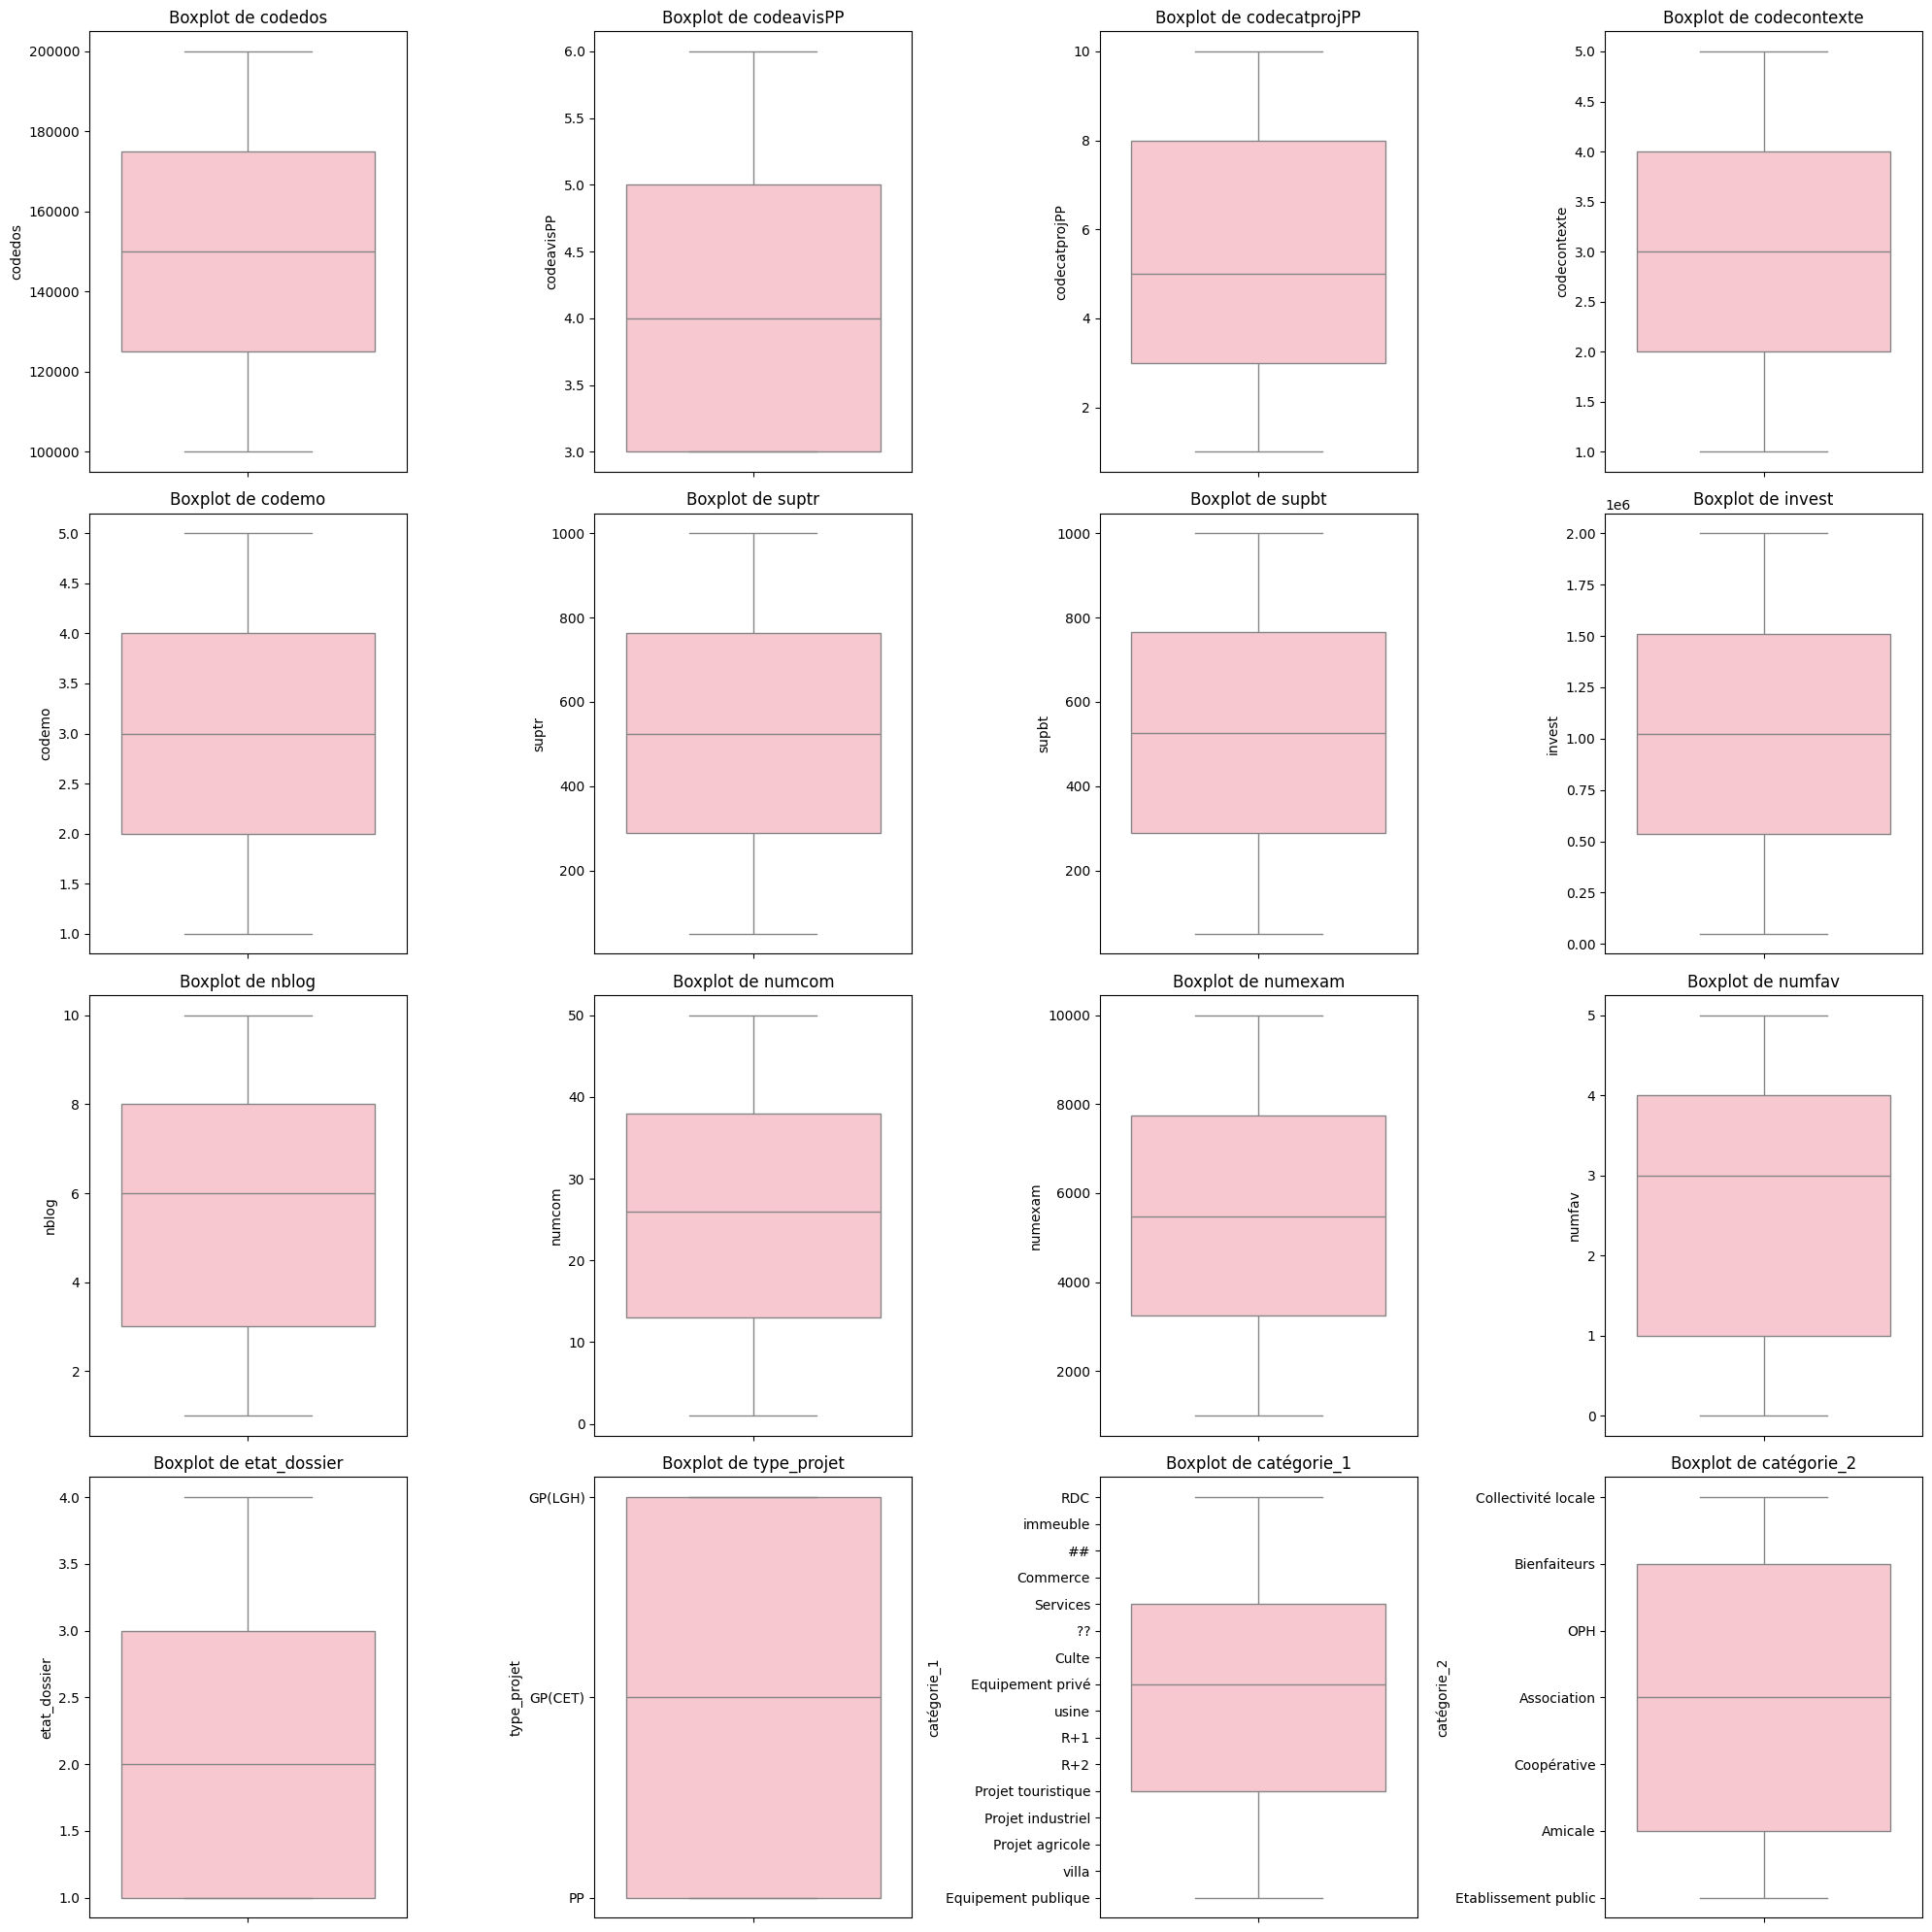

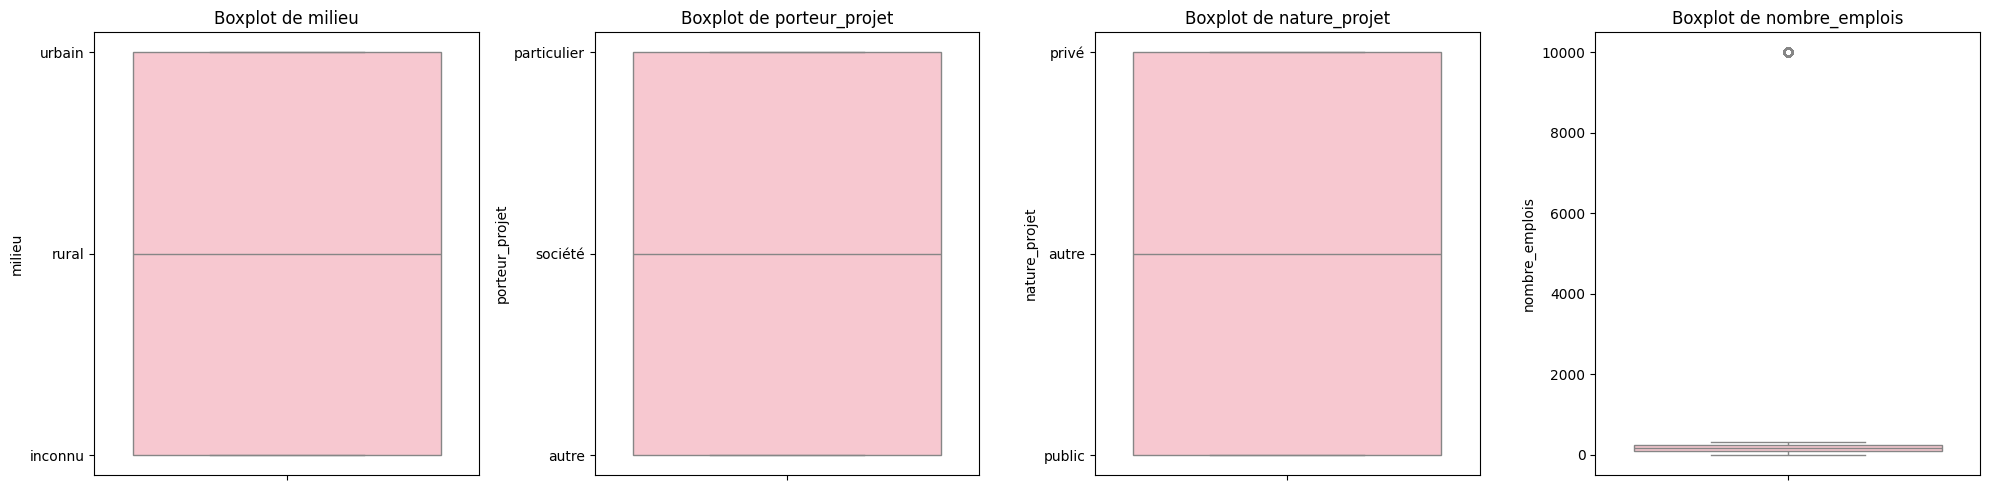

In [22]:
# Liste des variables numériques à tracer
numerical_featuresb = ['codedos', 'codeavisPP','codecatprojPP',
       'codecontexte', 'codemo', 'suptr', 'supbt', 'invest', 'nblog',
        'numcom', 'numexam', 'numfav', 'etat_dossier', 'type_projet', 'catégorie_1',
       'catégorie_2', 'milieu', 'porteur_projet', 'nature_projet',
       'nombre_emplois']

# Affichage par groupes de 16 variables maximum
group_size = 16
for i in range(0, len(numerical_featuresb), group_size):
    features_batch = numerical_featuresb[i:i + group_size]
    n = len(features_batch)
    rows = (n + 3) // 4  # 4 colonnes, ajustement du nombre de lignes

    plt.figure(figsize=(20, 5 * rows))
    for j, col in enumerate(features_batch, 1):
        plt.subplot(rows, 4, j)
        sns.boxplot(y=df[col], color='pink')
        plt.title(f'Boxplot de {col}')
        plt.xlabel('')
    plt.tight_layout()
    plt.show()
